In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## sklearn
from sklearn.model_selection import train_test_split, cross_val_score, KFold, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import randint

# metrics
from sklearn.metrics import classification_report, mean_absolute_error, mean_squared_error, mean_squared_error, r2_score

##xgboost
import xgboost as xgb

#Guardar modelo
from joblib import dump
import joblib

sns.set(style="whitegrid")  # estilo bonito para seaborn

# Explicabilidad
import shap



/Users/andresmauriciotrianareina/miniconda3/envs/PruebEtraining/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# ETL

Se realiza la carga de los datos desde los archivos procesados en la etapa previa (extracción de bases de MySQL y MongoDB).
Se eliminan columnas innecesarias para el análisis, y se reordena la estructura del dataframe para enfocarnos en las siguientes variables:

* Datos de ventas: producto, tipo de compra, tienda.
* Características de tiendas: región, tamaño, número de empleados.
* Datos meteorológicos: lluvia (en mm).

Estas acciones permiten normalizar y estructurar el dataset para el análisis posterior y la modelización.

In [2]:
df = pd.read_csv('all_data.csv')
df.head()

,Unnamed: 0,id,factura_id,product_id,fecha_venta,tipo_compra_id,id_product,nombre,id_type,tipo,...,longitud,id_region,nombre_region,id_size,escala,sensor_id_cercano,distancia_km,Sensor_id,fecha,lluvia_mm
0,0,1,1,14,2024-01-01 08:00:00,2,14,Tacos de pollo o carne,2,En línea,...,-74.082441,3,Este,1,Pequeño,13.0,0.652390,13,2024-01-01 08:00:00,10852.0
1,1,2,1,15,2024-01-01 08:00:00,2,15,Refrescos surtidos,2,En línea,...,-74.082441,3,Este,1,Pequeño,13.0,0.652390,13,2024-01-01 08:00:00,10852.0
2,2,3,2,1,2024-01-01 08:00:00,2,1,Hamburguesa clásica,2,En línea,...,-74.072496,3,Este,2,Mediano,11.0,1.349391,11,2024-01-01 08:00:00,1034.0
3,3,4,2,7,2024-01-01 08:00:00,2,7,Papas fritas clásicas,2,En línea,...,-74.072496,3,Este,2,Mediano,11.0,1.349391,11,2024-01-01 08:00:00,1034.0
4,4,5,2,15,2024-01-01 08:00:00,2,15,Refrescos surtidos,2,En línea,...,-74.072496,3,Este,2,Mediano,11.0,1.349391,11,2024-01-01 08:00:00,1034.0


In [3]:
df.tail()

,Unnamed: 0,id,factura_id,product_id,fecha_venta,tipo_compra_id,id_product,nombre,id_type,tipo,...,longitud,id_region,nombre_region,id_size,escala,sensor_id_cercano,distancia_km,Sensor_id,fecha,lluvia_mm
208858,208858,208859,85935,7,2024-12-30 21:00:00,1,7,Papas fritas clásicas,1,Presencial,...,-74.071331,1,Norte,2,Mediano,1.0,2.644683,1,2024-12-30 21:00:00,1157.0
208859,208859,208860,85935,15,2024-12-30 21:00:00,1,15,Refrescos surtidos,1,Presencial,...,-74.071331,1,Norte,2,Mediano,1.0,2.644683,1,2024-12-30 21:00:00,1157.0
208860,208860,208861,85936,6,2024-12-30 21:00:00,2,6,Sándwich de pulled pork,2,En línea,...,-74.089871,4,Sur,3,Grande,12.0,0.700002,12,2024-12-30 21:00:00,11601.0
208861,208861,208862,85936,7,2024-12-30 21:00:00,2,7,Papas fritas clásicas,2,En línea,...,-74.089871,4,Sur,3,Grande,12.0,0.700002,12,2024-12-30 21:00:00,11601.0
208862,208862,208863,85936,17,2024-12-30 21:00:00,2,17,Limonada natural o frozen,2,En línea,...,-74.089871,4,Sur,3,Grande,12.0,0.700002,12,2024-12-30 21:00:00,11601.0


In [4]:
df.describe()

,Unnamed: 0,id,factura_id,product_id,tipo_compra_id,id_product,id_type,id_ventas,tienda_id,id_tienda,...,tamaño_id,empleados,latitud,longitud,id_region,id_size,sensor_id_cercano,distancia_km,Sensor_id,lluvia_mm
count,208863.000000,208863.000000,208863.000000,208863.000000,208863.000000,208863.000000,208863.000000,208863.000000,208863.000000,208863.000000,...,208863.000000,208863.000000,208863.000000,208863.000000,208863.000000,208863.000000,208863.000000,208863.000000,208863.000000,208863.000000
mean,104431.000000,104432.000000,42962.050933,10.968204,1.493271,10.968204,1.493271,42962.050933,4.547522,4.547522,...,2.311051,14.282989,4.637962,-74.093450,2.501415,2.311051,8.219694,1.309173,8.219694,8751.355439
std,60293.698974,60293.698974,24810.656499,5.242142,0.499956,5.242142,0.499956,24810.656499,2.527555,2.527555,...,0.695514,3.921070,0.053743,0.039776,1.118513,0.695514,4.838439,0.648667,4.838439,3905.841138
min,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,5.000000,4.555034,-74.213006,1.000000,1.000000,1.000000,0.385363,1.000000,0.000000
25%,52215.500000,52216.500000,21481.000000,7.000000,1.000000,7.000000,1.000000,21481.000000,2.000000,2.000000,...,2.000000,12.000000,4.585923,-74.129521,1.000000,2.000000,3.000000,0.700002,3.000000,8782.000000
50%,104431.000000,104432.000000,42979.000000,12.000000,1.000000,12.000000,1.000000,42979.000000,4.000000,4.000000,...,2.000000,15.000000,4.616622,-74.082441,3.000000,2.000000,11.000000,1.349391,11.000000,10446.000000
75%,156646.500000,156647.500000,64456.000000,15.000000,2.000000,15.000000,2.000000,64456.000000,6.000000,6.000000,...,3.000000,17.000000,4.689609,-74.071331,4.000000,3.000000,12.000000,1.669893,12.000000,11221.000000
max,208862.000000,208863.000000,85936.000000,20.000000,2.000000,20.000000,2.000000,85936.000000,10.000000,10.000000,...,3.000000,20.000000,4.724168,-74.038500,4.000000,3.000000,17.000000,2.644683,17.000000,11999.000000


In [5]:
df.columns

Index(['Unnamed: 0', 'id', 'factura_id', 'product_id', 'fecha_venta',
       'tipo_compra_id', 'id_product', 'nombre', 'id_type', 'tipo',
       'id_ventas', 'tienda_id', 'id_tienda', 'region_id', 'tamaño_id',
       'empleados', 'latitud', 'longitud', 'id_region', 'nombre_region',
       'id_size', 'escala', 'sensor_id_cercano', 'distancia_km', 'Sensor_id',
       'fecha', 'lluvia_mm'],
      dtype='object')

In [6]:
new_column_order = [
    'fecha_venta', 'factura_id', 'product_id', 'nombre', 'tipo_compra_id','tipo',
    'tienda_id', 'region_id', 'nombre_region','tamaño_id', 'escala','empleados', 
    'latitud', 'longitud',
    'Sensor_id', 'distancia_km','lluvia_mm'
]

df = df[new_column_order]

df.head()

,fecha_venta,factura_id,product_id,nombre,tipo_compra_id,tipo,tienda_id,region_id,nombre_region,tamaño_id,escala,empleados,latitud,longitud,Sensor_id,distancia_km,lluvia_mm
0,2024-01-01 08:00:00,1,14,Tacos de pollo o carne,2,En línea,8,3,Este,1,Pequeño,5,4.576474,-74.082441,13,0.652390,10852.0
1,2024-01-01 08:00:00,1,15,Refrescos surtidos,2,En línea,8,3,Este,1,Pequeño,5,4.576474,-74.082441,13,0.652390,10852.0
2,2024-01-01 08:00:00,2,1,Hamburguesa clásica,2,En línea,6,3,Este,2,Mediano,15,4.616622,-74.072496,11,1.349391,1034.0
3,2024-01-01 08:00:00,2,7,Papas fritas clásicas,2,En línea,6,3,Este,2,Mediano,15,4.616622,-74.072496,11,1.349391,1034.0
4,2024-01-01 08:00:00,2,15,Refrescos surtidos,2,En línea,6,3,Este,2,Mediano,15,4.616622,-74.072496,11,1.349391,1034.0


## EDA

Se aplican diferentes visualizaciones para entender el comportamiento de las variables más relevantes:

### Histograma de lluvias

Analiza la cantidad de precipitación observada

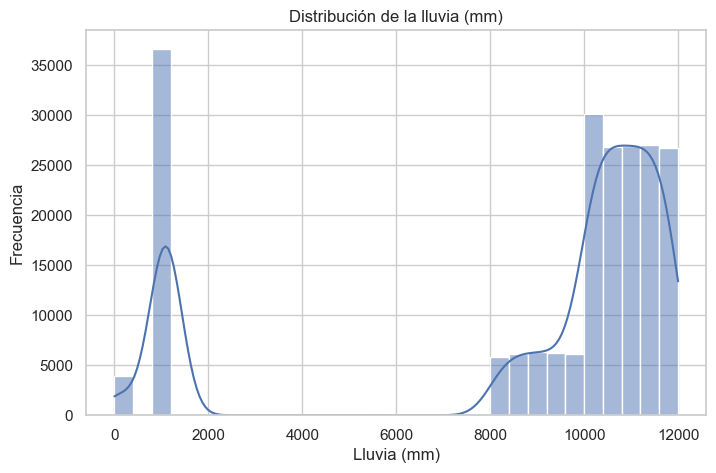

In [7]:
plt.figure(figsize=(8,5))
sns.histplot(df['lluvia_mm'], bins=30, kde=True)
plt.title('Distribución de la lluvia (mm)')
plt.xlabel('Lluvia (mm)')
plt.ylabel('Frecuencia')
plt.show()


### Boxplot lluvia vs tipo de venta

Relación de lluvias con diferentes tipos de ventas y zonas geográficas

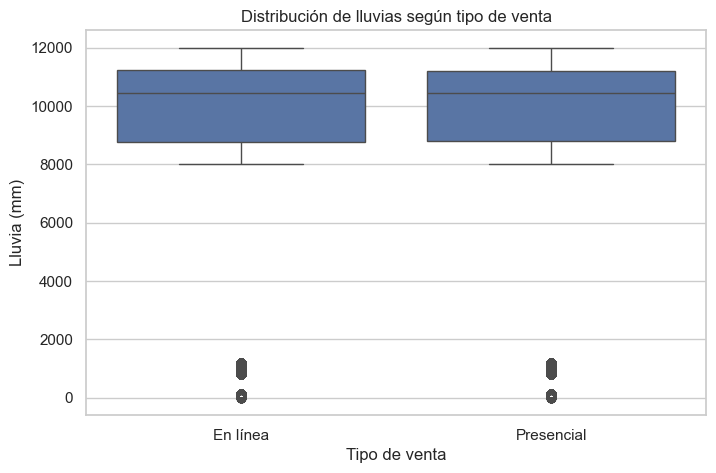

In [8]:
plt.figure(figsize=(8,5))
sns.boxplot(x='tipo', y='lluvia_mm', data=df)
plt.title('Distribución de lluvias según tipo de venta')
plt.xlabel('Tipo de venta')
plt.ylabel('Lluvia (mm)')
plt.show()


### Boxplot lluvia vs región

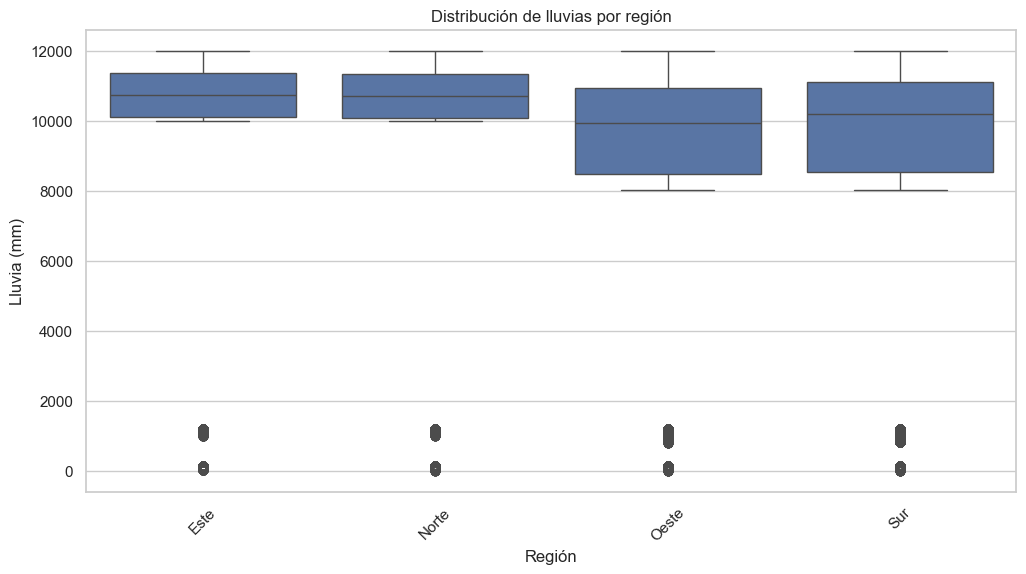

In [9]:
plt.figure(figsize=(12,6))
sns.boxplot(x='nombre_region', y='lluvia_mm', data=df)
plt.title('Distribución de lluvias por región')
plt.xlabel('Región')
plt.ylabel('Lluvia (mm)')
plt.xticks(rotation=45)
plt.show()

### Conteo de tipo de venta

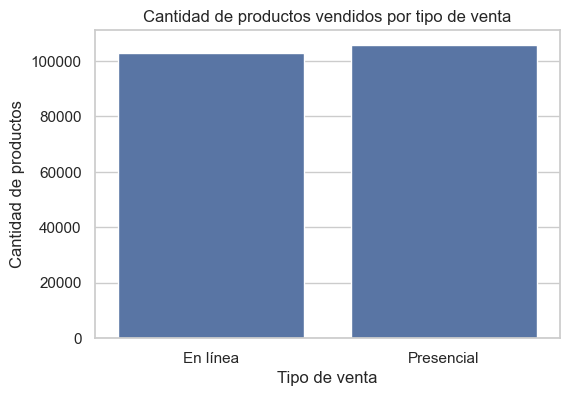

In [10]:
plt.figure(figsize=(6,4))
sns.countplot(x='tipo', data=df)
plt.title('Cantidad de productos vendidos por tipo de venta')
plt.xlabel('Tipo de venta')
plt.ylabel('Cantidad de productos')
plt.show()

### Productos más vendidos

Identifica los artículos más comercializados.

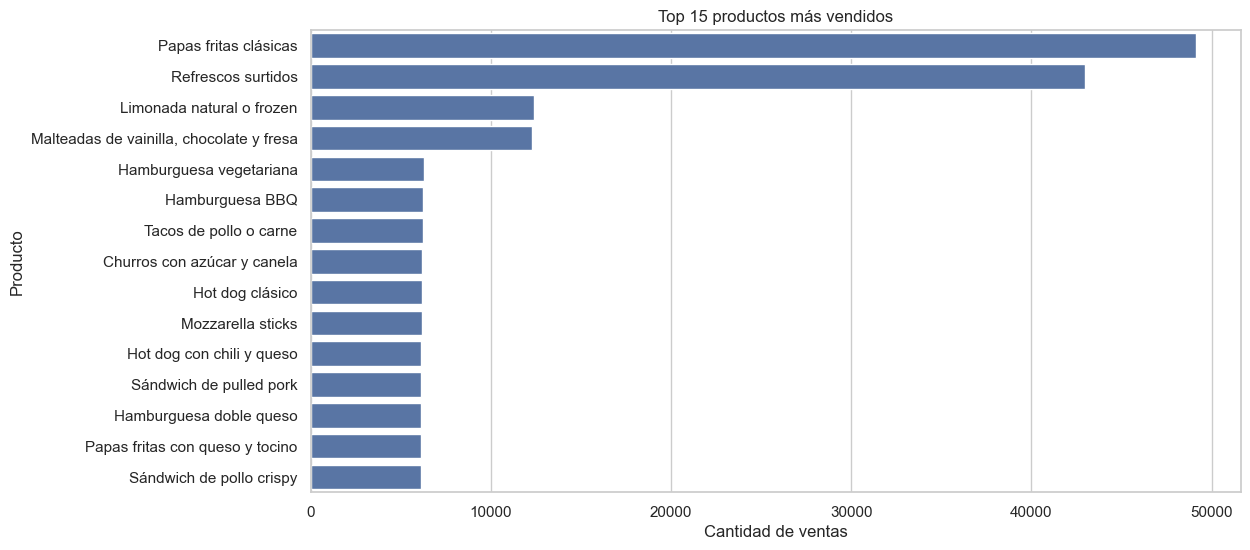

In [11]:
plt.figure(figsize=(12,6))
top_products = df['nombre'].value_counts().head(15)  # Top 15 productos

sns.barplot(x=top_products.values, y=top_products.index)
plt.title('Top 15 productos más vendidos')
plt.xlabel('Cantidad de ventas')
plt.ylabel('Producto')
plt.show()


### Matriz de correlación (variables numéricas)

Determina correlaciones entre variables numéricas (por ejemplo, lluvia, empleados, ventas)

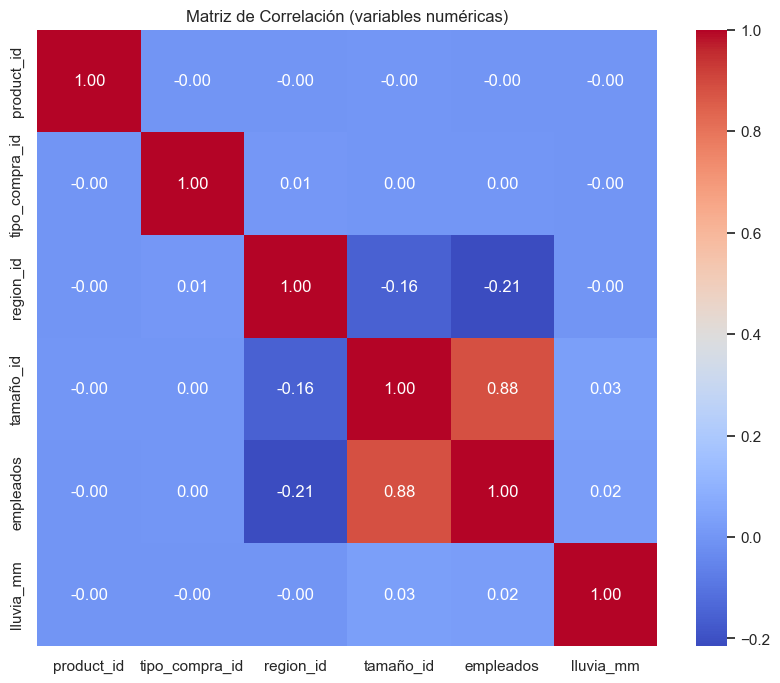

In [12]:
df_corr = df.copy()

numerical_cols = ['product_id', 'tipo_compra_id', 'region_id', 'tamaño_id', 'empleados', 'lluvia_mm']

# Matriz de correlación
corr = df_corr[numerical_cols].corr() 

plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación (variables numéricas)')
plt.show()

### Ventas por región

Entiende la distribución de ventas por las regiones

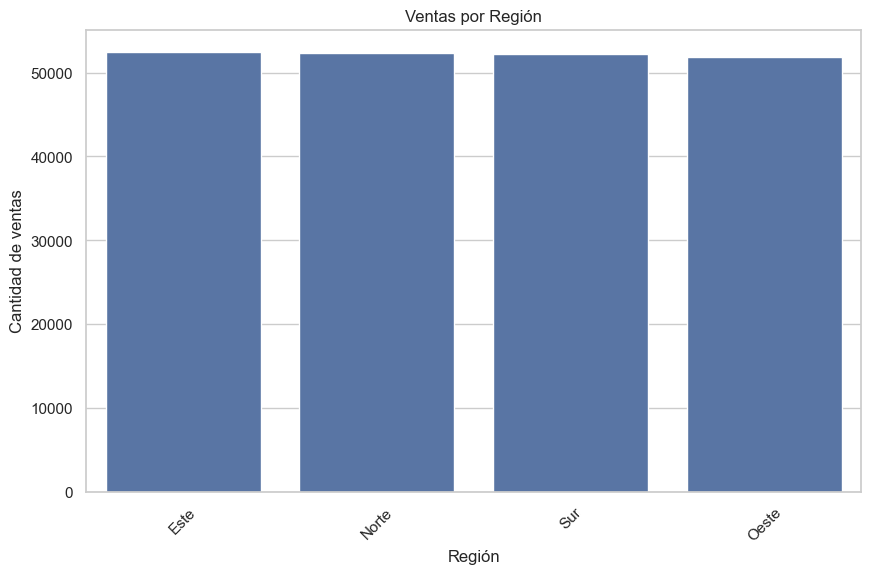

In [13]:
plt.figure(figsize=(10,6))
ventas_region = df['nombre_region'].value_counts()

sns.barplot(x=ventas_region.index, y=ventas_region.values)
plt.title('Ventas por Región')
plt.xlabel('Región')
plt.ylabel('Cantidad de ventas')
plt.xticks(rotation=45)
plt.show()

### Ventas por escala de tienda (tamaño)

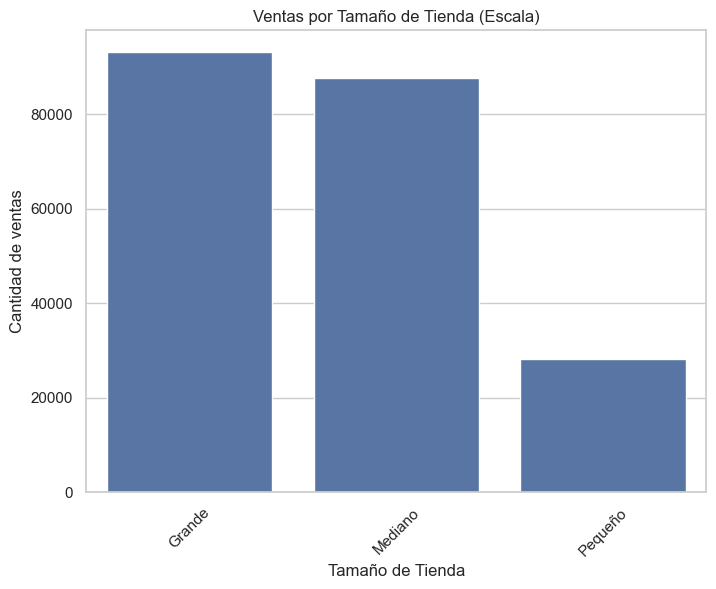

In [14]:
plt.figure(figsize=(8,6))
ventas_escala = df['escala'].value_counts()

sns.barplot(x=ventas_escala.index, y=ventas_escala.values)
plt.title('Ventas por Tamaño de Tienda (Escala)')
plt.xlabel('Tamaño de Tienda')
plt.ylabel('Cantidad de ventas')
plt.xticks(rotation=45)
plt.show()

### Correlación entre empleados y ventas

Se verifica si la cantidad de empleados y el tamaño de las tiendas tiene relacion en la venta de los prductos

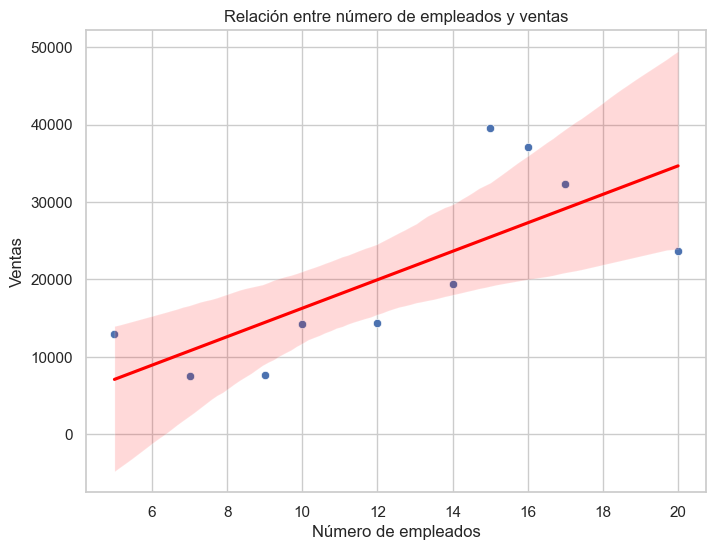

In [15]:
ventas_empleados = df.groupby('tienda_id').agg({
    'empleados': 'mean',
    'product_id': 'count'
}).reset_index().rename(columns={'product_id': 'ventas'})

# Scatterplot
plt.figure(figsize=(8,6))
sns.scatterplot(x='empleados', y='ventas', data=ventas_empleados)
sns.regplot(x='empleados', y='ventas', data=ventas_empleados, scatter=False, color='red')
plt.title('Relación entre número de empleados y ventas')
plt.xlabel('Número de empleados')
plt.ylabel('Ventas')
plt.show()

### Lluvia promedio por región

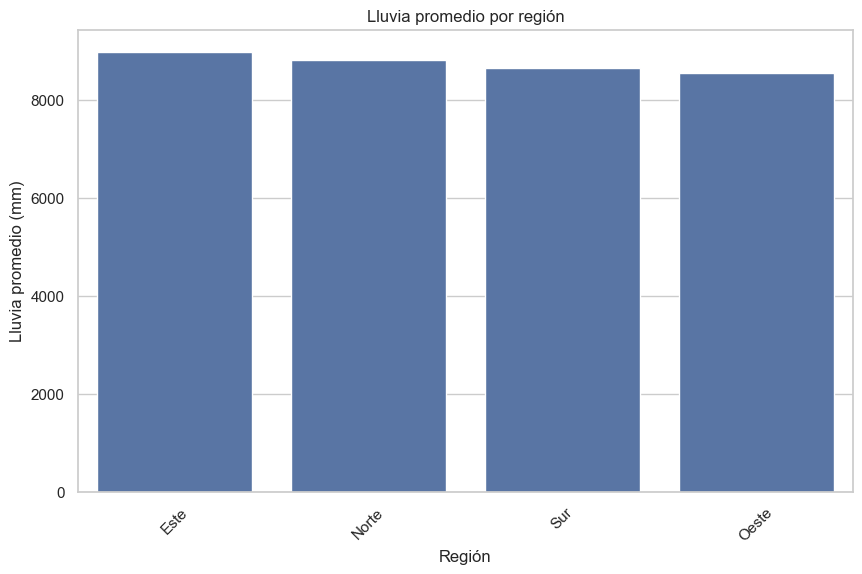

In [16]:
plt.figure(figsize=(10,6))
lluvia_region = df.groupby('nombre_region')['lluvia_mm'].mean().sort_values(ascending=False)

sns.barplot(x=lluvia_region.index, y=lluvia_region.values)
plt.title('Lluvia promedio por región')
plt.xlabel('Región')
plt.ylabel('Lluvia promedio (mm)')
plt.xticks(rotation=45)
plt.show()

### Distribución de ventas por hora

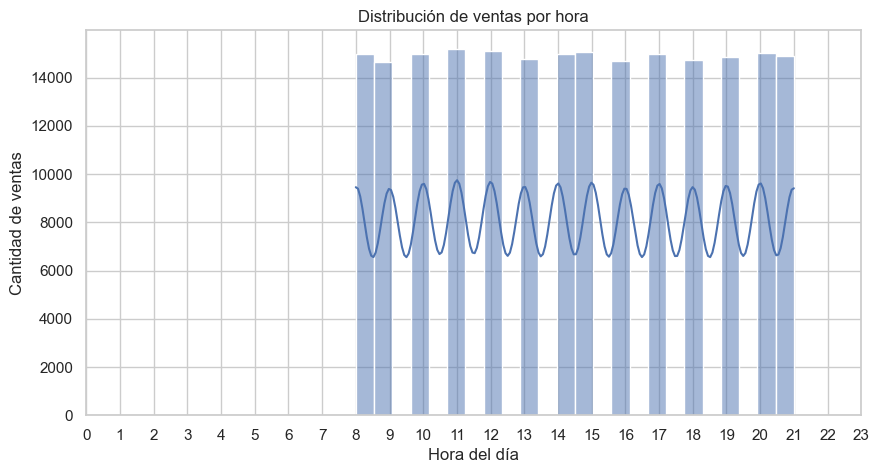

In [17]:
df['fecha_venta'] = pd.to_datetime(df['fecha_venta'])

# Crear columna de hora
df['hora_venta'] = df['fecha_venta'].dt.hour

# Histograma de ventas por hora
plt.figure(figsize=(10,5))
sns.histplot(df['hora_venta'], bins=24, kde=True)
plt.title('Distribución de ventas por hora')
plt.xlabel('Hora del día')
plt.ylabel('Cantidad de ventas')
plt.xticks(range(0,24))
plt.show()


## Entrenar modelo 1 por dia

Se genera un nuevo dataframe agrupado:

* Agrupaciones por tienda, región, tamaño de tienda y tipo de compra.
* Se calculan ventas como conteo de productos vendidos.
* Se calcula la lluvia promedio por grupo.

De esta forma, cada fila representa una combinación específica de tienda, región y condiciones meteorológicas, simplificando el modelo predictivo.

In [18]:
columns_to_trian = [
    'fecha_venta', 
    'product_id', 'nombre', 
    'tipo_compra_id','tipo',
    'tienda_id', 'region_id', 'nombre_region','tamaño_id', 'escala','empleados', 
    'Sensor_id', 'distancia_km', 'lluvia_mm'
]

df_train = df[columns_to_trian]

df_train.head()

,fecha_venta,product_id,nombre,tipo_compra_id,tipo,tienda_id,region_id,nombre_region,tamaño_id,escala,empleados,Sensor_id,distancia_km,lluvia_mm
0,2024-01-01 08:00:00,14,Tacos de pollo o carne,2,En línea,8,3,Este,1,Pequeño,5,13,0.652390,10852.0
1,2024-01-01 08:00:00,15,Refrescos surtidos,2,En línea,8,3,Este,1,Pequeño,5,13,0.652390,10852.0
2,2024-01-01 08:00:00,1,Hamburguesa clásica,2,En línea,6,3,Este,2,Mediano,15,11,1.349391,1034.0
3,2024-01-01 08:00:00,7,Papas fritas clásicas,2,En línea,6,3,Este,2,Mediano,15,11,1.349391,1034.0
4,2024-01-01 08:00:00,15,Refrescos surtidos,2,En línea,6,3,Este,2,Mediano,15,11,1.349391,1034.0


In [19]:
df_train['fecha_venta'] = pd.to_datetime(df_train['fecha_venta'])  # aseguramos datetime
df_train['mes'] = df_train['fecha_venta'].dt.month
df_train['dia_semana'] = df_train['fecha_venta'].dt.dayofweek  # Lunes=0, Domingo=6
# df_train['hora'] = df_train['fecha_venta'].dt.hour  # extraemos la hora


df_model = df_train.groupby(['tienda_id', 'region_id', 'tamaño_id', 'tipo_compra_id', 'mes', 'dia_semana', 'Sensor_id']).agg({
    'product_id': 'count',
    'empleados': 'mean',
    'lluvia_mm': 'mean',
    'distancia_km': 'mean'

}).reset_index()

# Renombramos columnas
df_model = df_model.rename(columns={'product_id': 'ventas'})

df_model.head()

/var/folders/1h/h2l8075n2rqgxl5mtv23jp740000gn/T/ipykernel_3335/2747227428.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['fecha_venta'] = pd.to_datetime(df_train['fecha_venta'])  # aseguramos datetime
/var/folders/1h/h2l8075n2rqgxl5mtv23jp740000gn/T/ipykernel_3335/2747227428.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['mes'] = df_train['fecha_venta'].dt.month
/var/folders/1h/h2l8075n2rqgxl5mtv23jp740000gn/T/ipykernel_3335/2747227428.py:3: SettingWithCopyWarning: 
A value is t

,tienda_id,region_id,tamaño_id,tipo_compra_id,mes,dia_semana,Sensor_id,ventas,empleados,lluvia_mm,distancia_km
0,1,1,3,1,1,0,1,125,20.0,9909.640000,1.669893
1,1,1,3,1,1,1,1,156,20.0,7591.961538,1.669893
2,1,1,3,1,1,2,1,143,20.0,8901.454545,1.669893
3,1,1,3,1,1,3,1,129,20.0,8292.581395,1.669893
4,1,1,3,1,1,4,1,124,20.0,7306.991935,1.669893


In [20]:
df_model.tail()

,tienda_id,region_id,tamaño_id,tipo_compra_id,mes,dia_semana,Sensor_id,ventas,empleados,lluvia_mm,distancia_km
1675,10,4,1,2,12,2,17,26,9.0,8939.692308,0.830014
1676,10,4,1,2,12,3,17,26,9.0,5849.500000,0.830014
1677,10,4,1,2,12,4,17,32,9.0,8472.593750,0.830014
1678,10,4,1,2,12,5,17,30,9.0,7572.033333,0.830014
1679,10,4,1,2,12,6,17,41,9.0,8222.682927,0.830014


In [21]:
X = df_model[['tienda_id', 'region_id', 'tamaño_id', 'tipo_compra_id', 'mes', 'dia_semana', 'empleados', 'Sensor_id', 'distancia_km', 'lluvia_mm']]

# Y
y = df_model['ventas']

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Se entrenan cuatro tipos de modelos de regresión para predecir la cantidad de ventas:

* Linear Regression (modelo base lineal)
* Decision Tree Regressor
* Random Forest Regressor
* XGBoost Regressor

In [23]:
# Modelos a evaluar
# Modelos a evaluar
models = {
    "LinearRegressionH": LinearRegression(fit_intercept=True),
    
    "DecisionTreeRegressorH": DecisionTreeRegressor(
        max_depth=20, 
        min_samples_split=5, 
        min_samples_leaf=2, 
        max_features='sqrt',
        random_state=42
    ),
    
    "RandomForestRegressorH": RandomForestRegressor(
        n_estimators=500, 
        max_depth=30,
        min_samples_split=5,
        min_samples_leaf=2,
        max_features='sqrt',
        bootstrap=True,
        random_state=42
    ),
    
    "XGBRegressorH": xgb.XGBRegressor(
        n_estimators=500,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        gamma=0.1,
        reg_alpha=0.1,
        reg_lambda=1,
        random_state=42,
        tree_method="hist"  # Aceleración para CPU
    )
}


Cada modelo es evaluado usando las siguientes métricas:

* MAE (Error absoluto medio)
* MSE (Error cuadrático medio)
* RMSE (Raíz del error cuadrático medio)
* R² Score (Coeficiente de determinación)

In [24]:
# Diccionario para almacenar resultados
results = {
    "Model": [],
    "MAE": [],
    "MSE": [],
    "RMSE": [],
    "R2": []
}

################################################
########################  LinearRegressionH
################################################

MAE: 31.89, MSE: 1711.60, RMSE: 41.37, R2: 0.67
Modelo LinearRegressionH guardado correctamente.



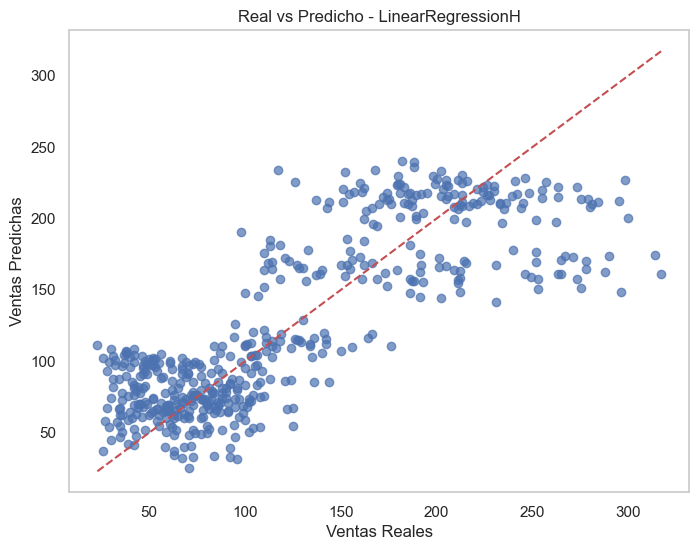

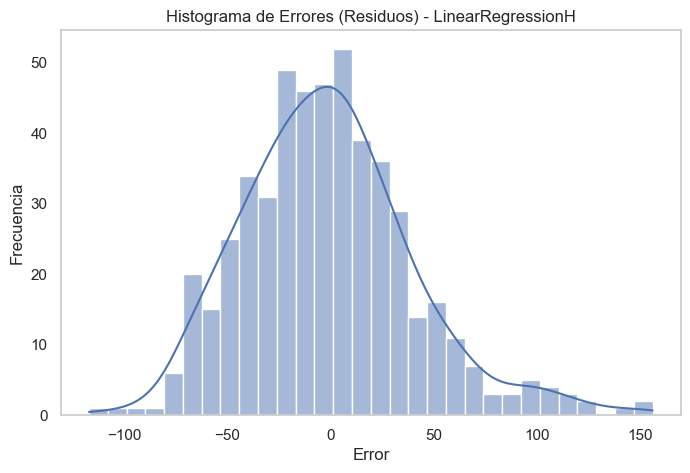

################################################
########################  DecisionTreeRegressorH
################################################

MAE: 24.81, MSE: 1066.72, RMSE: 32.66, R2: 0.79
Modelo DecisionTreeRegressorH guardado correctamente.



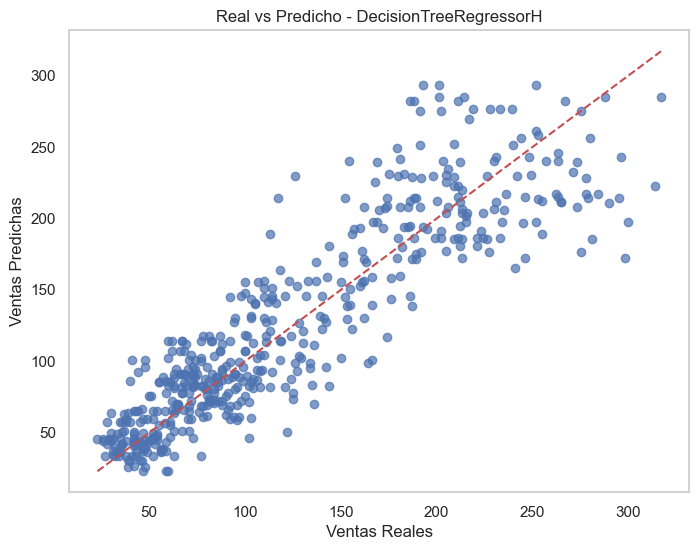

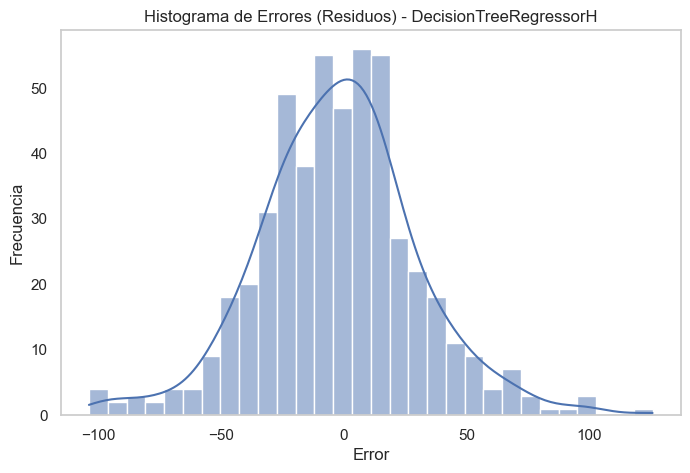

################################################
########################  RandomForestRegressorH
################################################

MAE: 19.90, MSE: 713.85, RMSE: 26.72, R2: 0.86
Modelo RandomForestRegressorH guardado correctamente.



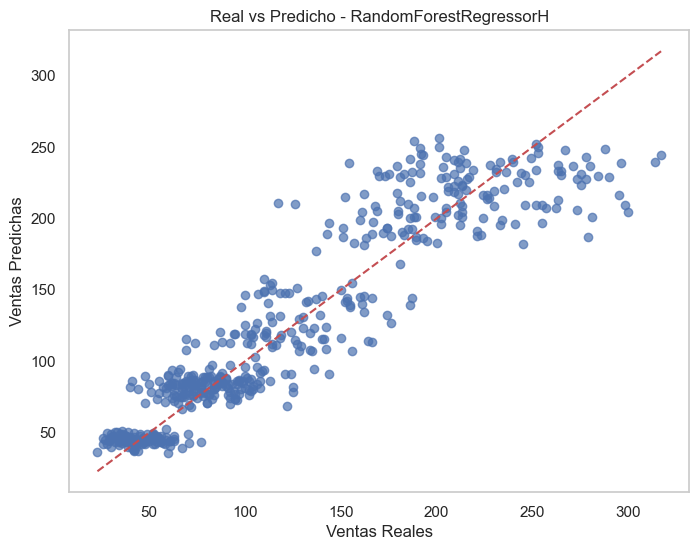

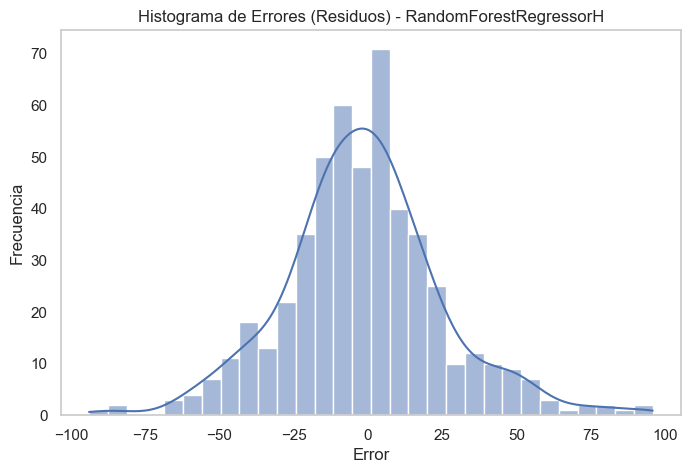

################################################
########################  XGBRegressorH
################################################

MAE: 19.58, MSE: 686.36, RMSE: 26.20, R2: 0.87
Modelo XGBRegressorH guardado correctamente.



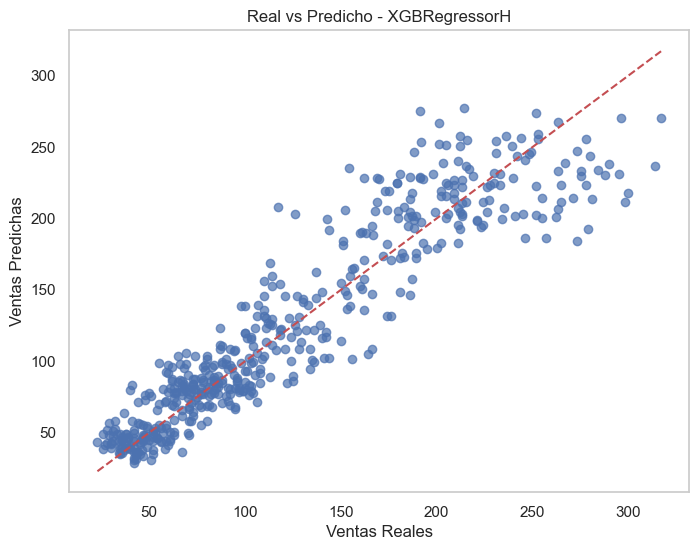

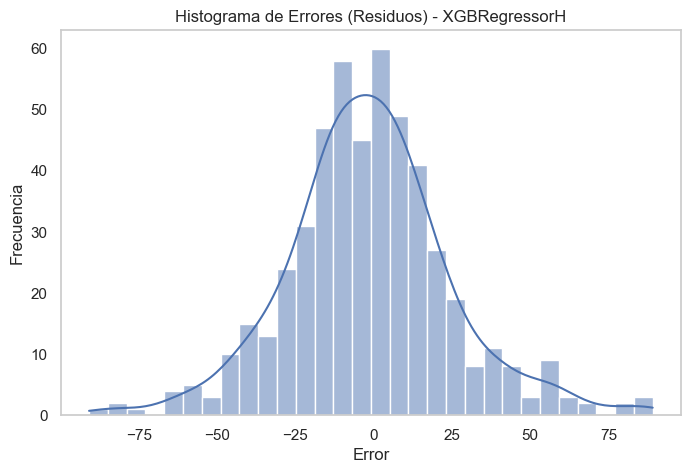

In [25]:
# Entrenar y evaluar cada modelo
for name, model in models.items():
    print("################################################")
    print(f"########################  {name}")
    print("################################################\n")

    try:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Calcular métricas
        MAE = mean_absolute_error(y_test, y_pred)
        MSE = mean_squared_error(y_test, y_pred)
        RMSE = np.sqrt(MSE)
        R2 = r2_score(y_test, y_pred)

        # Guardar resultados
        results["Model"].append(name)
        results["MAE"].append(MAE)
        results["MSE"].append(MSE)
        results["RMSE"].append(RMSE)
        results["R2"].append(R2)

        print(f"MAE: {MAE:.2f}, MSE: {MSE:.2f}, RMSE: {RMSE:.2f}, R2: {R2:.2f}")

        # Guardar modelo entrenado
        dump(model, f"{name}.joblib")
        print(f"Modelo {name} guardado correctamente.\n")

        # -----------------------------------
        # 1. Graficar Real vs Predicho
        plt.figure(figsize=(8,6))
        plt.scatter(y_test, y_pred, alpha=0.7)
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
        plt.xlabel('Ventas Reales')
        plt.ylabel('Ventas Predichas')
        plt.title(f'Real vs Predicho - {name}')
        plt.grid()
        plt.show()

        # -----------------------------------
        # 2. Graficar histograma de residuos
        residuals = y_test - y_pred
        plt.figure(figsize=(8,5))
        sns.histplot(residuals, bins=30, kde=True)
        plt.title(f'Histograma de Errores (Residuos) - {name}')
        plt.xlabel('Error')
        plt.ylabel('Frecuencia')
        plt.grid()
        plt.show()

    except Exception as e:
        print(f"Error en modelo {name}: {e}")


Se realiza una comparación entre modelos basada en el R² obtenido:

RandomForestRegressor fue el modelo con mejor desempeño global (mayor R²).
Se grafican los errores de predicción (residuos) y la relación real vs predicho.

In [26]:
# Mostrar resumen de resultados
results_df = pd.DataFrame(results)
results_df.sort_values(by="R2", ascending=False)

,Model,MAE,MSE,RMSE,R2
3,XGBRegressorH,19.583473,686.355896,26.198395,0.867650
2,RandomForestRegressorH,19.904901,713.846072,26.717898,0.862349
1,DecisionTreeRegressorH,24.808135,1066.724006,32.660741,0.794304
0,LinearRegressionH,31.889276,1711.598511,41.371470,0.669953


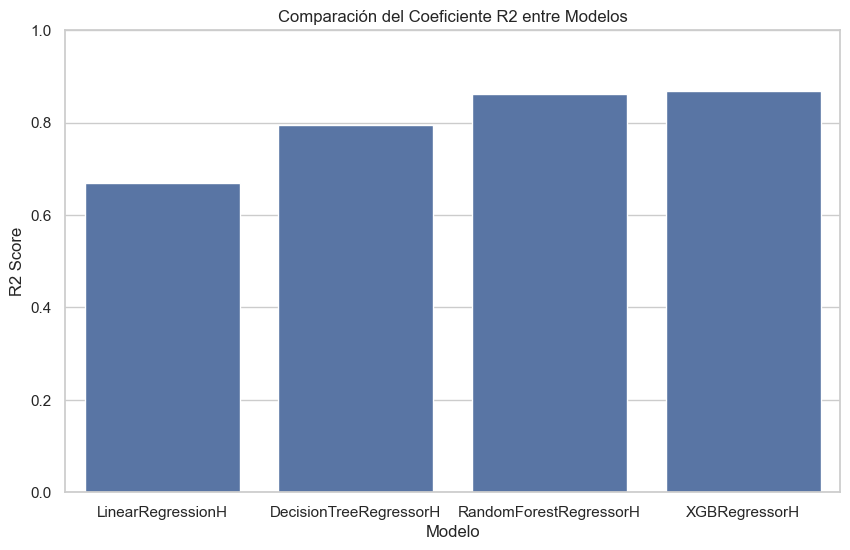

In [27]:
# Comparación de R2
plt.figure(figsize=(10,6))
sns.barplot(x="Model", y="R2", data=results_df)
plt.title("Comparación del Coeficiente R2 entre Modelos")
plt.xlabel("Modelo")
plt.ylabel("R2 Score")
plt.ylim(0,1)
plt.show()

### Verificar en diferentes split de datos

Se aplica validación cruzada de 5 pliegues para obtener una medida más robusta del desempeño de los modelos.

* Para cada modelo, se calcula el R² promedio y la desviación estándar en distintos splits.
* Se confirma que RandomForest y LinearRegression mantienen un R² aceptable y generalizable.

Cross-validation ayuda a validar que los modelos no estén sobreajustados a un solo conjunto de datos.

In [28]:
# Configurar 5-Fold Cross Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [29]:
# DataFrame para almacenar resultados de CV
cv_results = {
    "Model": [],
    "R2 Mean": [],
    "R2 Std": []
}

In [30]:
for name, model in models.items():
    print(f"\nEvaluando modelo con Cross-Validation: {name}")
    
    try:
        # Hacer cross_val_score usando r2 como scoring
        r2_scores = cross_val_score(model, X, y, cv=kf, scoring='r2')
        
        # Guardar resultados
        cv_results["Model"].append(name)
        cv_results["R2 Mean"].append(r2_scores.mean())
        cv_results["R2 Std"].append(r2_scores.std())

        print(f"R2 Mean: {r2_scores.mean():.4f}, Std: {r2_scores.std():.4f}")

    except Exception as e:
        print(f"Error en modelo {name}: {e}")

# Mostrar resultados ordenados
cv_results_df = pd.DataFrame(cv_results)
cv_results_df.sort_values('R2 Mean', ascending=False)


Evaluando modelo con Cross-Validation: LinearRegressionH
R2 Mean: 0.6630, Std: 0.0206

Evaluando modelo con Cross-Validation: DecisionTreeRegressorH
R2 Mean: 0.8062, Std: 0.0235

Evaluando modelo con Cross-Validation: RandomForestRegressorH
R2 Mean: 0.8634, Std: 0.0130

Evaluando modelo con Cross-Validation: XGBRegressorH
Error en modelo XGBRegressorH: 'super' object has no attribute '__sklearn_tags__'


,Model,R2 Mean,R2 Std
2,RandomForestRegressorH,0.863399,0.012979
1,DecisionTreeRegressorH,0.806163,0.023528
0,LinearRegressionH,0.663030,0.020593


### Analisis de residuos

Se analizan los errores (residuos) de cada modelo:

* Se grafican histogramas de errores y boxplots.
* Se aplicó la regla 1.5 * IQR para detectar outliers en las predicciones.

----------------------------------------------------
Análisis de residuos para el modelo: LinearRegressionH
----------------------------------------------------
count    504.000000
mean      -1.275337
std       41.392893
min     -117.033571
25%      -27.767564
50%       -2.980687
75%       22.507907
max      156.061639
Name: ventas, dtype: float64


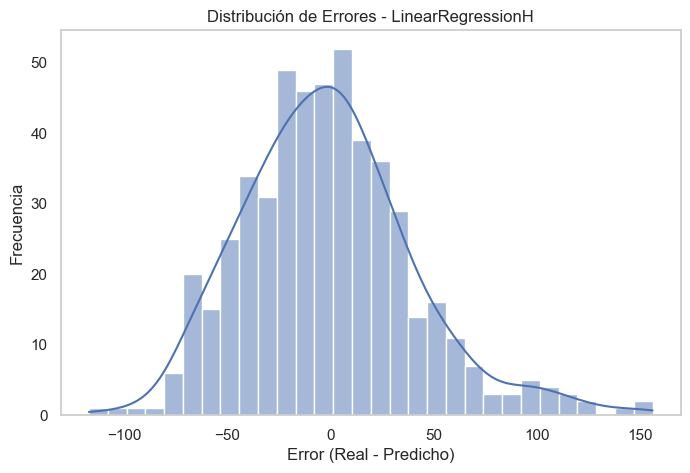

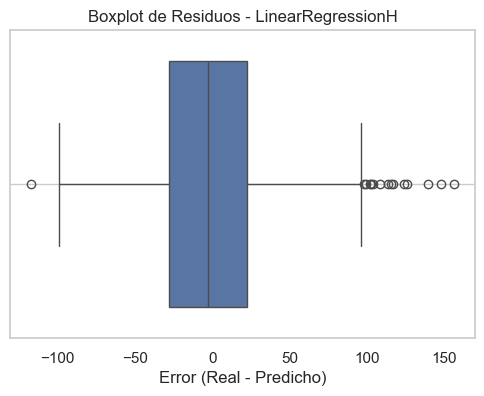

Número de outliers detectados: 15 de 504 (2.98%)
----------------------------------------------------
Análisis de residuos para el modelo: DecisionTreeRegressorH
----------------------------------------------------
count    504.000000
mean      -2.256415
std       32.615076
min     -104.000000
25%      -22.541667
50%       -2.000000
75%       16.000000
max      126.000000
Name: ventas, dtype: float64


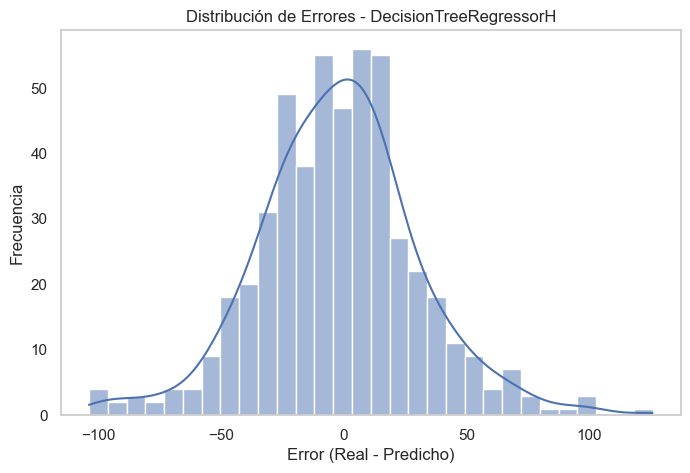

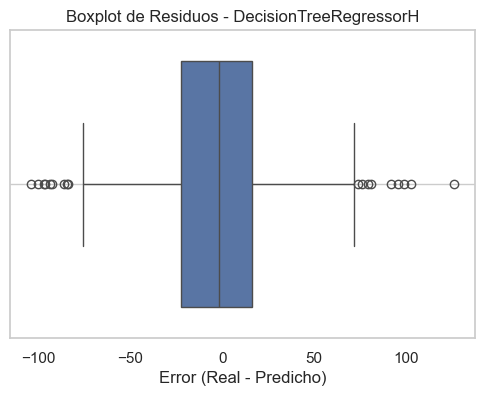

Número de outliers detectados: 18 de 504 (3.57%)
----------------------------------------------------
Análisis de residuos para el modelo: RandomForestRegressorH
----------------------------------------------------
count    504.000000
mean      -1.654970
std       26.693087
min      -93.867084
25%      -16.891746
50%       -2.182931
75%       12.495865
max       95.766447
Name: ventas, dtype: float64


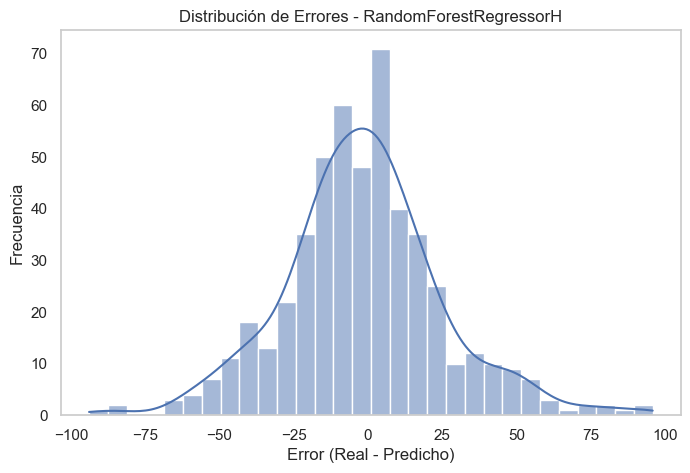

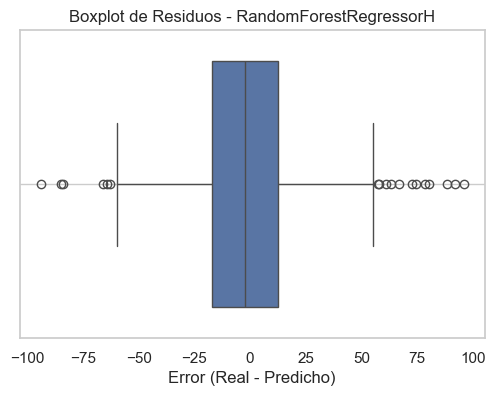

Número de outliers detectados: 18 de 504 (3.57%)
----------------------------------------------------
Análisis de residuos para el modelo: XGBRegressorH
----------------------------------------------------
count    504.000000
mean      -1.551705
std       26.178385
min      -90.871567
25%      -15.497478
50%       -1.686914
75%       12.490764
max       89.118103
Name: ventas, dtype: float64


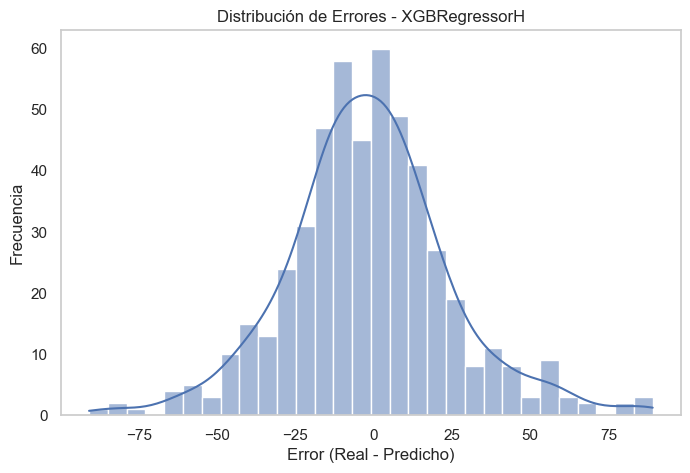

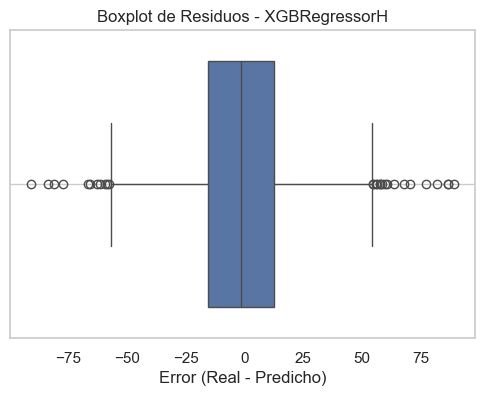

Número de outliers detectados: 28 de 504 (5.56%)


In [31]:
# Evaluar residuos y detectar outliers
for name, model in models.items():
    print("----------------------------------------------------")
    print(f"Análisis de residuos para el modelo: {name}")
    print("----------------------------------------------------")
    
    try:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        residuals = y_test - y_pred

        # Estadísticas básicas
        print(residuals.describe())

        # Graficar distribución de residuos
        plt.figure(figsize=(8,5))
        sns.histplot(residuals, bins=30, kde=True)
        plt.title(f'Distribución de Errores - {name}')
        plt.xlabel('Error (Real - Predicho)')
        plt.ylabel('Frecuencia')
        plt.grid()
        plt.show()

        # Graficar Boxplot de residuos
        plt.figure(figsize=(6,4))
        sns.boxplot(x=residuals)
        plt.title(f'Boxplot de Residuos - {name}')
        plt.xlabel('Error (Real - Predicho)')
        plt.grid()
        plt.show()

        # Contar outliers usando regla 1.5*IQR
        Q1 = residuals.quantile(0.25)
        Q3 = residuals.quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        num_outliers = ((residuals < lower_bound) | (residuals > upper_bound)).sum()
        total = len(residuals)

        print(f"Número de outliers detectados: {num_outliers} de {total} ({(num_outliers/total)*100:.2f}%)")

    except Exception as e:
        print(f"Error analizando residuos en {name}: {e}")


Se encontró una cantidad muy baja de outliers, lo cual indica predicciones estables

# Explicabilidad global y local modelo 1

Se utiliza la librería SHAP para interpretar el modelo RandomForest:

### Local

* Valores positivos en rojo indican características que aumentan la predicción del modelo.
* Valores negativos en azul indican características que reducen el valor de la predicción del modelo

Para observaciones individuales, se visualiza el impacto de cada variable en la predicción final mediante gráficos waterfall.

In [32]:
# Obtener importancia global de las características del modelo RandomFerest
# Explicabilidad con SHAP

model = joblib.load("RandomForestRegressorH.joblib")


explainer = shap.TreeExplainer(model)
shap_values = explainer(X_train)

np.shape(shap_values.values)


(1176, 10)

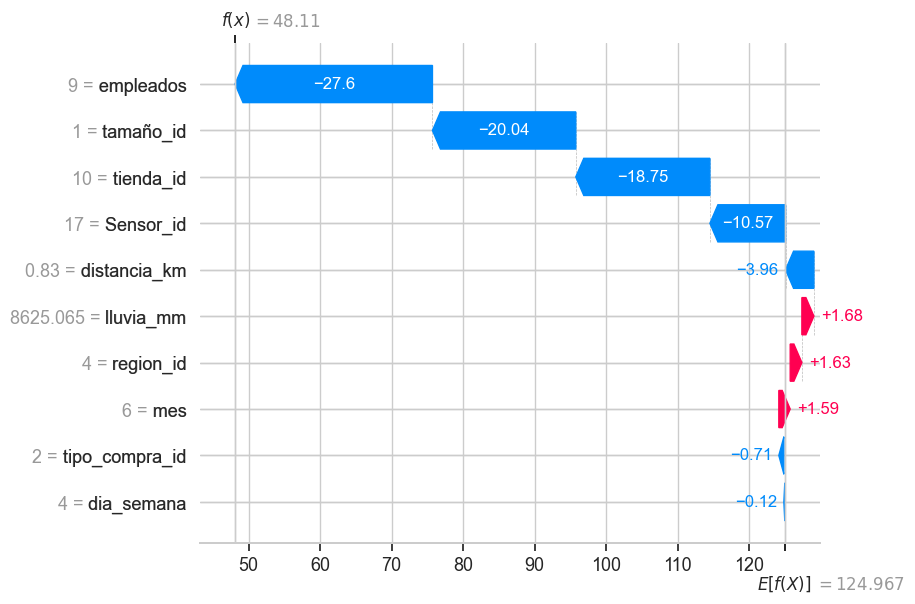

In [33]:
shap.plots.waterfall(shap_values[0])

### Global

* Se calcula la importancia promedio de cada característica.
* Valores positivos en rojo indican características que aumentan la predicción del modelo.
* Valores negativos en azul indican características que reducen el valor de la predicción del modelo

In [34]:
# Calcular la importancia global promediando los valores absolutos
shap_importance = np.abs(shap_values.values).mean(axis=0)

# Crear DataFrame con la importancia global
importance_df = pd.DataFrame({'Feature': X_train.columns.tolist(), 'SHAP Importance': shap_importance})
importance_df = importance_df.sort_values(by="SHAP Importance", ascending=False)

importance_df

,Feature,SHAP Importance
6,empleados,28.758416
2,tamaño_id,10.387922
0,tienda_id,9.628958
7,Sensor_id,9.048833
1,region_id,6.252618
8,distancia_km,3.126445
9,lluvia_mm,2.927615
5,dia_semana,1.605486
3,tipo_compra_id,1.566198
4,mes,1.546178


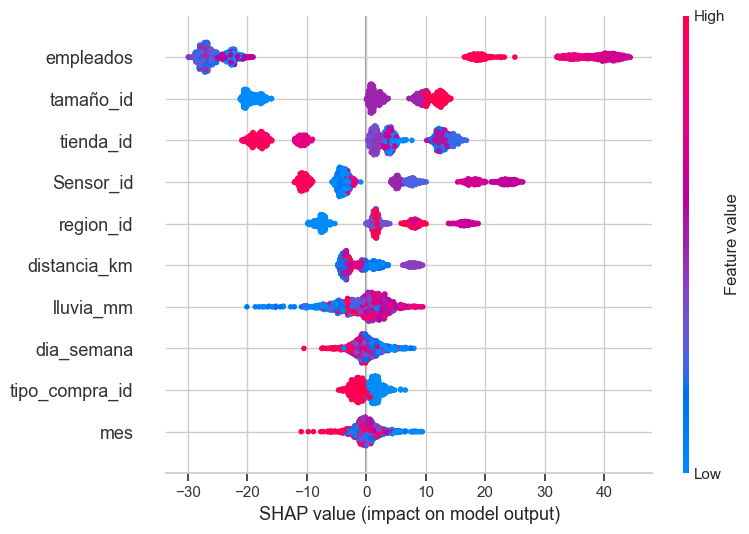

In [35]:
# Visualización de importancia global de características
shap.summary_plot(shap_values, X_train)

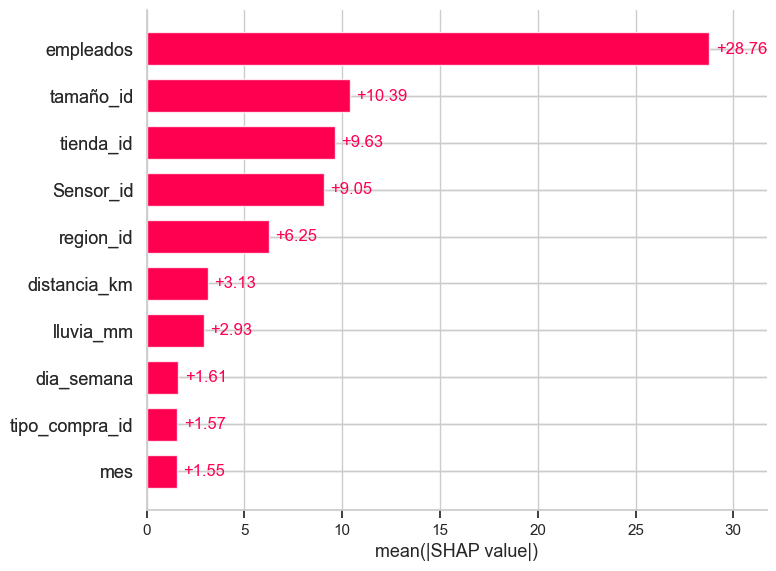

In [36]:
### Absolute MEAN SHAP

shap.plots.bar(shap_values)

## Conclusiones

Resultados y Conclusiones

* La variable "lluvia" impacta moderadamente en las ventas.
* El modelo Random Forest logra capturar mejor las relaciones no lineales entre variables.
* La cantidad de empleados y el tamaño de la tienda también son variables relevantes.
* La información meteorológica mejoró ligeramente la capacidad predictiva.